In [1]:
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import imageio
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import cv2
from matplotlib.colors import hsv_to_rgb
import geojson
from pyproj import Proj
UTM_10_PROJ = Proj("+proj=utm +zone=10N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")


(10000, 10000, 3) uint8


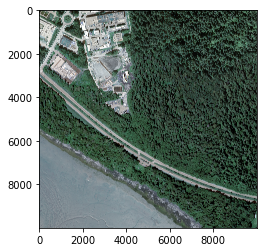

In [2]:
os.chdir(os.path.join(et.io.HOME, "ubc/capstone/orthophoto/2014"))
image = cv2.imread('483E_5454N.tif')
type(image)
print(image.shape, image.dtype)
plt.imshow(image)
nemo = image[:5000, :5000, :]
hsv_nemo = cv2.cvtColor(nemo[:5000,:5000,:], cv2.COLOR_RGB2HSV)

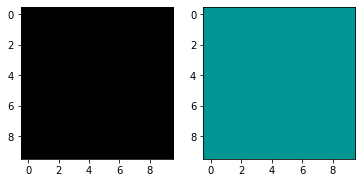

In [3]:
dark_green = (50/360*255,0, 0)
light_green = (180/360*255, 255, 150)
lo_square = np.full((10, 10, 3), light_green, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_green, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

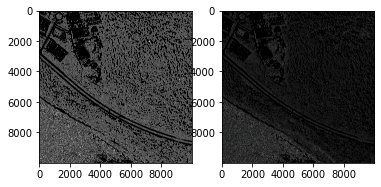

0:00:05.584457


In [4]:
blurred_image = ndimage.gaussian_filter(image, sigma=4)
startTime = datetime.now()
nemo = blurred_image
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_nemo, dark_green, light_green)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()
print(datetime.now() - startTime)

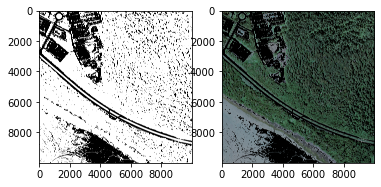

0:00:05.575212


In [5]:
kernel = np.ones((20,20),np.float32)/400
blurred_image = cv2.filter2D(image,-1,kernel)
startTime = datetime.now()
nemo = blurred_image
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_nemo, dark_green, light_green)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()
print(datetime.now() - startTime)

In [6]:
def stddev_above_threshold(x,y,window_size, threshold,im):
    r = im[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size, 0:3]
    return r.std() > threshold

0:00:07.221748


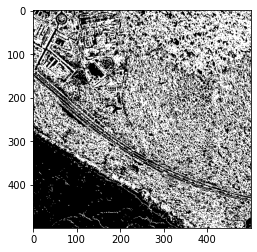

In [7]:
blurred_image = ndimage.gaussian_filter(image, sigma=2)
n = 500
startTime = datetime.now()
stddev_array = np.array([stddev_above_threshold(i//n,i%n,20,12,blurred_image) for i in range(0,n**2)]).reshape(n,n)
print(datetime.now() - startTime)
plt.imshow(stddev_array, cmap=plt.cm.gray)

0:00:09.464252


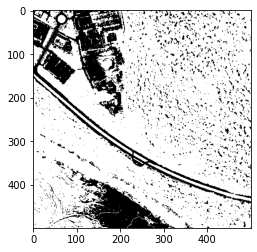

In [8]:
def compressed_green(x,y,window_size,green_mask):
    r = green_mask[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size]
    return r.mean() > 128
n = 500 
compressed_green_array = np.array([compressed_green(i//n,i%n,20,mask) for i in range(0,n**2)]).reshape(n,n)
plt.imshow(compressed_green_array, cmap=plt.cm.gray)
print(datetime.now() - startTime)

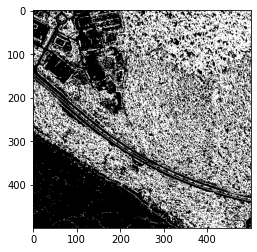

In [9]:
n=500
green_stddev_array = np.array([compressed_green_array[i//n,i%n] and stddev_array[i//n,i%n] for i in range(0,n**2)]).reshape(n,n)
plt.imsave("green_stddev.png", green_stddev_array)
plt.imshow(green_stddev_array,cmap=plt.cm.gray)

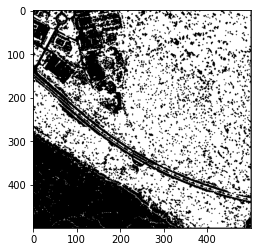

In [10]:
close_img = ndimage.binary_closing(green_stddev_array)
plt.imshow(close_img, cmap=plt.cm.gray)

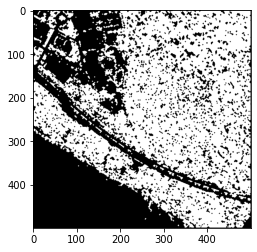

In [11]:
open_img = ndimage.binary_opening(close_img)
plt.imshow(open_img, cmap=plt.cm.gray)
plt.imsave("green_stddev.png", open_img)


In [12]:
im = cv2.imread('green_stddev.png')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)

In [13]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [14]:
len(contours)

172

In [15]:
def convert_to_lon_lat(polygon_10_m, utm_10_bot_left_coord):
    polygon_10_m = polygon_10_m/ 10
    polygon_10_m = [[x[0][0]+utm_10_bot_left_coord[0],1000-x[0][1]+utm_10_bot_left_coord[1]] for x in polygon_10_m]
    projected = [UTM_10_PROJ(x[0], x[1], inverse=True) for x in polygon_10_m]
    head = projected[0]
    projected.append(head)
    return projected
lon_lat = convert_to_lon_lat(contours[0]*20,[483000,5454000])
lon_lat

[(-123.22439177628999, 49.2387026484401),
 (-123.22441916997839, 49.23868460472268),
 (-123.22441908846557, 49.2386666143754),
 (-123.22439153178142, 49.238648677398146),
 (-123.22436413810276, 49.23866672110911),
 (-123.22436421959564, 49.238684711456465),
 (-123.22439177628999, 49.2387026484401)]

In [16]:
feature_list = []
for c in contours:
    lon_lat = convert_to_lon_lat(c*20,[483000,5454000])
    feature_list.append(geojson.Feature(geometry=geojson.Polygon([lon_lat])))
feature_collection = geojson.FeatureCollection(feature_list)

with open("polygons2.geojson", mode = "w") as out_file:
    geojson.dump(feature_collection,out_file)
